In [5]:
# SPA vs COIN_FF vs COIN_FF_RL (imitation of COIN_FF)

import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
import networkx as nx
import heapq

## 1. Load shapefile and build TrafficNetwork

In [6]:
# Path to your shapefile
path = "../trimmed_manhattan_shape/trimmed_manhattan.shp"
gdf = gpd.read_file(path)
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

# If CRS is geographic (lat/lon), reproject to EPSG:2263 (NY State Plane)
if gdf.crs is not None and gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=2263)
print("Reprojected CRS: ", gdf.crs)

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']
Reprojected CRS:  EPSG:2263


## 2. Core types

In [7]:
Node = Tuple[float, float]     # (x, y)
EdgeId = Tuple[Node, Node]     # directed edge
EdgeFlows = Dict[EdgeId, float]


@dataclass
class Edge:
    start: Node
    end: Node
    length_m: float       # meters
    v_free: float         # free-flow speed (m/s)
    capacity: float       # max cars that fit on this segment
    alpha: float = 0.15   # BPR parameters
    beta: float = 4.0

    @property
    def free_time(self) -> float:
        """Free-flow travel time (seconds)."""
        return self.length_m / self.v_free

    def travel_time(self, flow: float) -> float:
        """BPR-style congestion travel time (seconds)."""
        x = flow / self.capacity if self.capacity > 0 else 0.0
        return self.free_time * (1.0 + self.alpha * (x ** self.beta))


Graph = Dict[Node, List[EdgeId]]


@dataclass
class TrafficNetwork:
    graph: Graph
    edges: Dict[EdgeId, Edge]


def make_node(x: float, y: float, ndigits: int = 3) -> Node:
    """Rounding keeps nodes consistent instead of tiny float differences."""
    return round(x, ndigits), round(y, ndigits)


## 3. Stochastic edge parameters

## Constants

In [8]:
# --- Capacity tuning constants (put near top of file) ---
# Default lanes by OSM 'highway' tag (very rough)
HIGHWAY_DEFAULT_LANES = {
    "motorway": 6,
    "trunk": 5,
    "primary": 5,
    "secondary": 4,
    "tertiary": 2,
    "residential": 2,
    "service": 2,
}

REF_SPEED = 13.89           # m/s ≈ 50 km/h
SPEED_CAPACITY_GAMMA = 0.2  # how strongly speed affects capacity

# Put these near the top of the file, next to your other globals
CAPACITY_SCALE = 20.0    # global multiplier for capacities
MIN_CAPACITY   = 500.0   # minimum cars per directed edge (model units)



In [9]:
def sample_car_length() -> float:
    # lognormal with median around 4.5m
    mu = math.log(4.5)
    sigma = 0.15
    length = random.lognormvariate(mu, sigma)
    return max(length, 3.5)  # clamp to > 3.5m


def sample_gap() -> float:
    # lognormal with median around 1.5m
    mu = math.log(1.5)
    sigma = 0.25
    gap = random.lognormvariate(mu, sigma)
    return max(gap, 0.5)


def sample_spacing() -> float:
    """Space per vehicle = car length + gap."""
    return sample_car_length() + sample_gap()


def sample_free_speed_time_based() -> float:
    """
    Sample free-flow speed via a lognormal model on time-per-meter.
    This gives a fatter tail toward low speeds.
    """
    median_s_per_m = 0.09  # ~40 km/h
    mu = math.log(median_s_per_m)
    sigma = 0.3  # spread; larger => more slow edges
    s_per_m = random.lognormvariate(mu, sigma)  # seconds per meter
    v_free = 1.0 / s_per_m  # m/s

    # clamp speeds to a plausible urban range ~ 18–90 km/h
    v_free = max(min(v_free, 25.0), 5.0)
    return v_free

def network_from_streets_gdf(streets_gdf: gpd.GeoDataFrame) -> TrafficNetwork:
    """
    Build a directed TrafficNetwork from a GeoDataFrame of street segments.

    Capacity is based on:
        - geometric length / spacing  (cars that fit on the segment)
        - free-flow speed (faster links get slightly higher capacity)
        - a global CAPACITY_SCALE (so capacities are large vs. agent flows)
        - a global MIN_CAPACITY (so no edge is absurdly small)

    The result is that, for your Manhattan test with ~100 agents,
    typical v/c ratios stay in a reasonable range instead of exploding.
    """
    graph: Dict[Node, List[EdgeId]] = defaultdict(list)
    edges: Dict[EdgeId, Edge] = {}

    for _, row in streets_gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue

        # Handle MultiLineString and LineString
        if isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, LineString):
            line_geoms = [geom]
        else:
            continue

        for line in line_geoms:
            coords = list(line.coords)
            if len(coords) < 2:
                continue

            for (x1, y1), (x2, y2) in zip(coords[:-1], coords[1:]):
                u = make_node(x1, y1)
                v = make_node(x2, y2)

                seg = LineString([(x1, y1), (x2, y2)])
                length_m = seg.length

                # --- stochastic spacing & free-flow speed ---
                spacing = sample_spacing()                # [m / car]
                v_free  = sample_free_speed_time_based()  # [m / s]

                # cars that physically fit on this small segment
                base_cars = max(length_m / spacing, 1.0)

                # modest boost for faster links (e.g. avenues vs local streets)
                v_ref = 15.0  # m/s ≈ 54 km/h
                speed_factor = max(v_free / v_ref, 0.5)   # avoid tiny factors

                # final capacity for this directed edge
                capacity = base_cars * speed_factor * CAPACITY_SCALE
                capacity = max(capacity, MIN_CAPACITY)

                # directed u -> v
                e1 = (u, v)
                if e1 not in edges:
                    edges[e1] = Edge(
                        start=u,
                        end=v,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[u].append(e1)

                # bidirectional by default
                e2 = (v, u)
                if e2 not in edges:
                    edges[e2] = Edge(
                        start=v,
                        end=u,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[v].append(e2)

    return TrafficNetwork(graph=dict(graph), edges=edges)


# Build network
manhattan_network = network_from_streets_gdf(gdf)
print(f"# nodes: {len(manhattan_network.graph)}")
print(f"# edges: {len(manhattan_network.edges)}")


# nodes: 37086
# edges: 81228


## 4. NetworkX conversion (for sanity plot)

# NX nodes: 37086 # NX edges: 81228


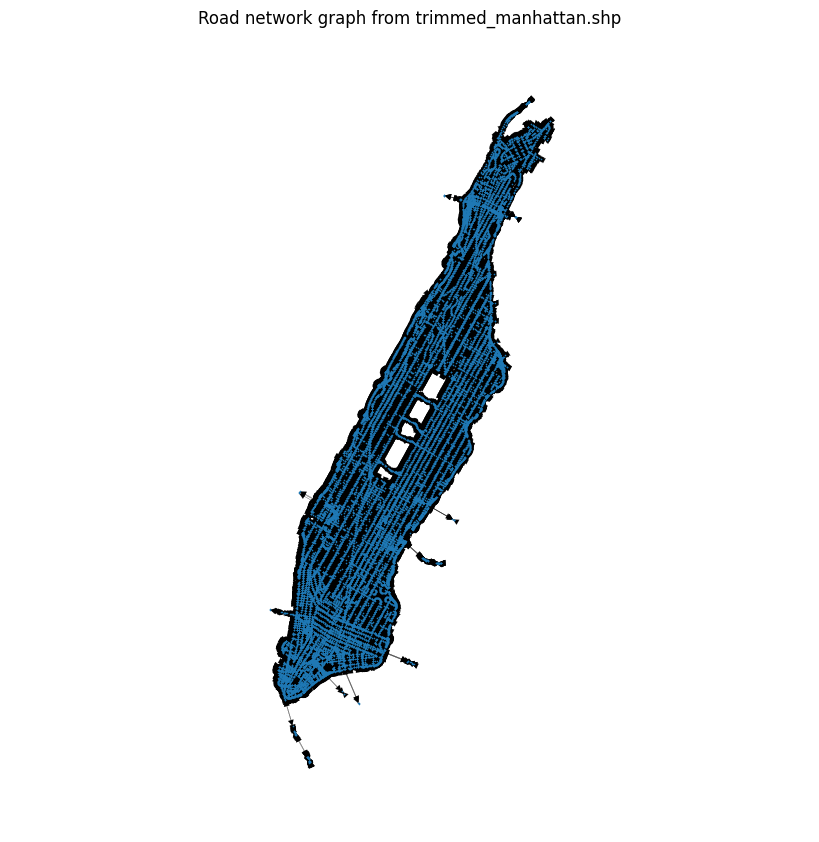

In [10]:
def to_networkx(network: TrafficNetwork) -> nx.DiGraph:
    G = nx.DiGraph()
    for node in network.graph.keys():
        G.add_node(node, x=node[0], y=node[1])
    for e_id, edge in network.edges.items():
        G.add_edge(edge.start, edge.end,
                   free_time=edge.free_time,
                   capacity=edge.capacity)
    return G


G_nx = to_networkx(manhattan_network)
print("# NX nodes:", G_nx.number_of_nodes(), "# NX edges:", G_nx.number_of_edges())

pos = {n: (n[0], n[1]) for n in G_nx.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(G_nx, pos=pos, node_size=1, linewidths=0.1, width=0.1)
plt.axis("equal")
plt.title("Road network graph from trimmed_manhattan.shp")
plt.show()

## 5. Agents + OD selection

In [11]:
@dataclass
class Agent:
    origin: Node
    destination: Node
    path: List[Node] = None


def sample_agents_random(network: TrafficNetwork, num_agents: int) -> List[Agent]:
    nodes = list(network.graph.keys())
    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(nodes)
        d = random.choice(nodes)
        while d == o:
            d = random.choice(nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def sample_agents_north_south(
    network: TrafficNetwork,
    num_agents: int,
    band_split: float = 0.5,
) -> List[Agent]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)
    y_mid = y_min + band_split * (y_max - y_min)

    north_nodes = [n for n in nodes if n[1] >= y_mid]
    south_nodes = [n for n in nodes if n[1] <= y_mid]
    assert north_nodes and south_nodes, "North/south bands empty – check CRS/band_split."

    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(north_nodes)
        d = random.choice(south_nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def pick_north_south_pair(network: TrafficNetwork) -> Tuple[Node, Node]:
    """Pick a single north–south OD pair to keep SPA / COIN_FF comparable."""
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)

    # north = top 20%, south = bottom 20%
    north_nodes = [n for n in nodes if n[1] >= y_min + 0.8 * (y_max - y_min)]
    south_nodes = [n for n in nodes if n[1] <= y_min + 0.2 * (y_max - y_min)]

    o = random.choice(north_nodes)
    d = random.choice(south_nodes)
    return o, d


def sample_agents_fixed(
    network: TrafficNetwork,
    num_agents: int,
    origin: Node,
    destination: Node
) -> List[Agent]:
    return [Agent(origin=origin, destination=destination) for _ in range(num_agents)]


## 6. Dijkstra (SPA) and marginal-cost Dijkstra (COIN_FF)

In [12]:
def dijkstra(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows
) -> List[Node]:
    """Standard Dijkstra where cost = current travel time t(flow)."""
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        d_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end
            w = edge.travel_time(edge_flows[edge_id])
            nd = d_u + w
            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if target not in dist:
        return []  # no path found

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path


def edge_marginal_cost(edge: Edge, flow_before: float) -> float:
    """
    Given that 'flow_before' cars already use this edge,
    what is the marginal increase in total system travel time G
    if we send one more car along it?
    """
    f1 = flow_before
    f2 = flow_before + 1
    t1 = edge.travel_time(f1)
    t2 = edge.travel_time(f2)
    G1 = f1 * t1
    G2 = f2 * t2
    return G2 - G1


def dijkstra_coin_ff_marginal(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows
) -> List[Node]:
    """
    Ford–Fulkerson style path search:
    shortest path where edge weight is the *marginal increase in G*
    if we send one additional car along that edge.
    Edges with flow >= capacity are treated as 'blocked'.
    """
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        cost_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end

            # Respect capacity (no residual capacity => no edge)
            if edge_flows[edge_id] >= edge.capacity:
                continue

            f_before = edge_flows[edge_id]
            marginal = edge_marginal_cost(edge, f_before)
            new_cost = cost_u + marginal

            if v not in dist or new_cost < dist[v]:
                dist[v] = new_cost
                prev[v] = u
                heapq.heappush(pq, (new_cost, v))

    if target not in dist:
        return []  # no path

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path


def edges_from_path(path: List[Node]) -> List[EdgeId]:
    return list(zip(path[:-1], path[1:]))



## 7. Routing: SPA and COIN_FF

In [13]:
def spa_route_all(network: TrafficNetwork, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """Selfish Path Assignment (SPA): each agent uses shortest travel-time path."""
    edge_flows: EdgeFlows = defaultdict(float)
    for agent in agents:
        path = dijkstra(network, agent.origin, agent.destination, edge_flows)
        agent.path = path
        for e in edges_from_path(path):
            edge_flows[e] += 1.0  # 1 vehicle per agent
    return agents, edge_flows


def coin_ff_route_all(network: TrafficNetwork, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """
    Ford–Fulkerson–style COIN:
    - For each agent, find a path that minimizes the marginal increase in G
      (using dijkstra_coin_ff_marginal).
    - Push 1 unit of flow along that path.
    """
    edge_flows: EdgeFlows = defaultdict(float)
    for agent in agents:
        path = dijkstra_coin_ff_marginal(
            network,
            agent.origin,
            agent.destination,
            edge_flows
        )
        agent.path = path
        for e in edges_from_path(path):
            edge_flows[e] += 1.0
    return agents, edge_flows


## 8. World utility & OD used for fixed experiments

In [14]:
def total_system_travel_time(network: TrafficNetwork, edge_flows: EdgeFlows) -> float:
    total = 0.0
    for e_id, flow in edge_flows.items():
        edge = network.edges[e_id]
        total += flow * edge.travel_time(flow)
    return total


# Fixed OD pair (global, to keep things simple and consistent)
origin, destination = pick_north_south_pair(manhattan_network)
zero_flows = defaultdict(float)
shortest_path = dijkstra(manhattan_network, origin, destination, zero_flows)
shortest_edges = set(edges_from_path(shortest_path))

print("Origin:", origin)
print("Destination:", destination)
print("Shortest path length (edges):", len(shortest_path))


def dist_to_dest(node: Node, dest: Node) -> float:
    return math.dist(node, dest)

Origin: (999777.138, 248891.757)
Destination: (982592.622, 196931.595)
Shortest path length (edges): 932


## 9. COIN_FF → Expert Dataset for Imitation Learning

In [28]:
def get_neighbors(network: TrafficNetwork, node: Node) -> List[Node]:
    return [network.edges[e_id].end for e_id in network.graph.get(node, [])]

# ==== RL constants (can re-use yours) ====
TIME_SCALE = 1000.0      # scales travel time when used as reward
TERMINAL_BONUS = 5.0     # reward when a step lands exactly on destination


def dist_to_dest(node: Node, dest: Node) -> float:
    """Euclidean distance (in coordinate units) from node to dest."""
    x1, y1 = node
    x2, y2 = dest
    return math.hypot(x2 - x1, y2 - y1)

# --- global RL constants (keep near the top of your RL section) ---
TIME_SCALE      = 1000.0   # scales travel times down
TERMINAL_BONUS  = 5.0      # extra reward for landing exactly on the destination
T_CAP           = 3600.0   # cap edge travel time in seconds when used in reward

def q_learning_train_coin_ff(
    network: TrafficNetwork,
    num_episodes: int = 30,
    num_agents_per_episode: int = 100,
    od_mode: str = "fixed",
    alpha: float = 0.3,
    gamma: float = 0.95,
    epsilon_start: float = 0.3,
    epsilon_end: float = 0.05,
    max_steps_per_agent: int = 2000,
    lambda_prog: float = 4.0,     # weight on progress-to-destination
    lambda_time: float = 0.02,    # weight on (scaled) travel time penalty
) -> Dict[Tuple[Node, Node, Node], float]:
    """
    True Q-learning that interacts with the traffic environment.

    Reward at each step:
        progress = d(s,d) - d(a,d)
        t_edge   = travel_time_e(flow_before)

        r =  λ_prog * progress
            - λ_time * min(t_edge, T_CAP) / TIME_SCALE
            + TERMINAL_BONUS * 1[a == d]

    • progress  > 0  if we move closer to the destination
    • travel_time term is negative and capped to avoid huge penalties
    """

    Q: Dict[Tuple[Node, Node, Node], float] = {}

    def sample_agents_for_mode(n_agents: int) -> List[Agent]:
        if od_mode == "random":
            return sample_agents_random(network, n_agents)
        elif od_mode in ("north_south", "north-south"):
            return sample_agents_north_south(network, n_agents)
        else:  # "fixed"
            return sample_agents_fixed(network, n_agents, origin, destination)

    for ep in range(num_episodes):
        # linear epsilon schedule
        if num_episodes > 1:
            epsilon = epsilon_start + (epsilon_end - epsilon_start) * ep / (num_episodes - 1)
        else:
            epsilon = epsilon_end

        edge_flows: EdgeFlows = defaultdict(float)
        agents = sample_agents_for_mode(num_agents_per_episode)

        total_returns = 0.0
        total_steps = 0

        for agent in agents:
            s = agent.origin
            d = agent.destination
            steps = 0
            G_ep = 0.0

            while s != d and steps < max_steps_per_agent:
                neighbors = get_neighbors(network, s)
                if not neighbors:
                    break

                # ε-greedy action selection using current Q
                if random.random() < epsilon:
                    a = random.choice(neighbors)
                else:
                    best_q = None
                    best_actions: List[Node] = []
                    for nxt in neighbors:
                        key = (s, d, nxt)
                        q_val = Q.get(key, 0.0)
                        if best_q is None or q_val > best_q:
                            best_q = q_val
                            best_actions = [nxt]
                        elif q_val == best_q:
                            best_actions.append(nxt)
                    a = random.choice(best_actions)

                edge_id = (s, a)
                if edge_id not in network.edges:
                    break

                edge = network.edges[edge_id]
                flow_before = edge_flows[edge_id]

                # --- reward shaping ---

                # (1) progress toward destination
                old_dist = dist_to_dest(s, d)
                new_dist = dist_to_dest(a, d)
                progress = old_dist - new_dist  # >0 if closer to dest

                # (2) travel-time penalty, capped & scaled
                t_edge = edge.travel_time(flow_before)
                t_capped = min(t_edge, T_CAP)
                t_scaled = t_capped / TIME_SCALE

                reward = (
                    lambda_prog * progress
                    - lambda_time * t_scaled
                )

                # (3) terminal bonus if we actually arrive
                if a == d:
                    reward += TERMINAL_BONUS

                # apply this agent's flow
                edge_flows[edge_id] += 1.0

                s_next = a
                done = (s_next == d) or (steps + 1 >= max_steps_per_agent)

                # --- Q-learning target ---
                if done:
                    target = reward
                else:
                    next_neighbors = get_neighbors(network, s_next)
                    if not next_neighbors:
                        target = reward
                    else:
                        max_q_next = max(
                            Q.get((s_next, d, nxt), 0.0) for nxt in next_neighbors
                        )
                        target = reward + gamma * max_q_next

                key = (s, d, a)
                old_q = Q.get(key, 0.0)
                Q[key] = old_q + alpha * (target - old_q)

                G_ep += reward
                total_steps += 1
                steps += 1
                s = s_next

            total_returns += G_ep

        avg_return = total_returns / max(len(agents), 1)
        avg_steps = total_steps / max(len(agents), 1)
        print(
            f"Episode {ep+1}/{num_episodes} | "
            f"eps={epsilon:.3f}, avg_return={avg_return:.3f}, avg_steps={avg_steps:.1f}"
        )

    print(f"Finished Q-learning with {len(Q)} learned (state,action) entries.")
    return Q


def route_with_trained_Q(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    num_agents: int = 200,
    od_mode: str = "fixed",
    max_steps_per_agent: int = 1500,
    fallback_mode: str = "free_time",  # "random" or "free_time"
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Evaluate a trained Q-table by routing agents and computing the resulting
    edge flows and total system travel time G.

    - Uses greedy actions wrt Q when available.
    - If Q has no info for any outgoing edge at a state,
      we fall back to either random choice or min free-flow time.
    """
    edge_flows: EdgeFlows = defaultdict(float)

    # sample new agents for evaluation
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    for agent in agents:
        s = agent.origin
        d = agent.destination
        path = [s]
        steps = 0
        visited: set[Node] = set()

        while s != d and steps < max_steps_per_agent:
            neighbors = get_neighbors(network, s)
            if not neighbors:
                break

            visited.add(s)

            # 1) try greedy Q if we have info
            best_q = None
            best_actions: List[Node] = []
            for a in neighbors:
                key = (s, d, a)
                if key not in Q:
                    continue
                q_val = Q[key]
                if best_q is None or q_val > best_q:
                    best_q = q_val
                    best_actions = [a]
                elif q_val == best_q:
                    best_actions.append(a)

            if best_actions:
                a = random.choice(best_actions)
            else:
                # 2) fallback policy if Q has no info
                if fallback_mode == "random":
                    a = random.choice(neighbors)
                else:  # "free_time"
                    unvisited = [nxt for nxt in neighbors if nxt not in visited]
                    candidates = unvisited if unvisited else neighbors
                    a = min(
                        candidates,
                        key=lambda nxt: network.edges[(s, nxt)].free_time,
                    )

            edge_id = (s, a)
            if edge_id not in network.edges:
                break

            edge_flows[edge_id] += 1.0
            s = a
            path.append(s)
            steps += 1

        agent.path = path

    G = total_system_travel_time(network, edge_flows)
    return agents, edge_flows, G



In [29]:
def run_spa_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "north_south"
) -> Tuple[List[Agent], EdgeFlows, float]:
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    elif od_mode == "fixed":
        agents = sample_agents_fixed(network, num_agents, origin, destination)
    else:
        raise ValueError(f"Unknown od_mode: {od_mode}")

    agents, edge_flows = spa_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"SPA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_SPA: {G:.2f}")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")
    return agents, edge_flows, G


def run_coin_ff_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "fixed"
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Ford–Fulkerson style COIN_FF experiment:
    routes agents using coin_ff_route_all and computes world utility G.
    """
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    agents, edge_flows = coin_ff_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"COIN_FF experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_COIN_FF: {G:.2f}")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")
    return agents, edge_flows, G


def run_coin_ff_true_rl_experiment(
    network: TrafficNetwork,
    num_agents_baseline: int = 100,
    num_agents_train: int = 100,
    num_agents_eval_rl: int = 100,
    od_mode: str = "fixed",
    num_episodes: int = 20,
) -> Tuple[
    List[Agent], EdgeFlows, float,
    List[Agent], EdgeFlows, float,
    List[Agent], EdgeFlows, float,
    Dict[Tuple[Node, Node, Node], float],
]:
    """
    1) SPA baseline
    2) COIN_FF baseline
    3) Train Q via true Q-learning interacting with the environment
    4) Evaluate COIN_FF_RL (greedy policy from learned Q)
    """
    # 1) SPA
    agents_spa, flows_spa, G_spa = run_spa_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
    )

    # 2) COIN_FF
    agents_coin_ff, flows_coin_ff, G_coin_ff = run_coin_ff_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
    )

    # 3) True RL training
    print("\n=== Training COIN_FF_RL via Q-learning ===")
    Q_rl = q_learning_train_coin_ff(
        network=network,
        num_episodes=num_episodes,
        num_agents_per_episode=num_agents_train,
        od_mode=od_mode,
    )

    # 4) Evaluate learned policy
    agents_coin_ff_rl, flows_coin_ff_rl, G_coin_ff_rl = route_with_trained_Q(
        network=network,
        Q=Q_rl,
        num_agents=num_agents_eval_rl,
        od_mode=od_mode,
        max_steps_per_agent=2000,
        fallback_mode="free_time",
    )

    print("\n=== Summary: SPA vs COIN_FF vs COIN_FF_RL(Q-learning) ===")
    print(f"G_SPA        = {G_spa:.2f}")
    print(f"G_COIN_FF    = {G_coin_ff:.2f}")
    print(f"G_COIN_FF_RL = {G_coin_ff_rl:.2f}")
    print(f"Improvement (COIN_FF vs SPA)    = {(G_spa - G_coin_ff) / G_spa * 100:.2f}%")
    print(f"Improvement (COIN_FF_RL vs SPA) = {(G_spa - G_coin_ff_rl) / G_spa * 100:.2f}%")

    return (
        agents_spa, flows_spa, G_spa,
        agents_coin_ff, flows_coin_ff, G_coin_ff,
        agents_coin_ff_rl, flows_coin_ff_rl, G_coin_ff_rl,
        Q_rl,
    )



## 11. Metrics & visualisation helpers

In [30]:
def fraction_reached(agents: List[Agent], dest: Node) -> float:
    reached = sum(1 for a in agents if a.path and a.path[-1] == dest)
    return reached / len(agents)


def compute_agent_travel_times(
        network: TrafficNetwork,
        edge_flows: EdgeFlows,
        agents: List[Agent]) -> List[float]:
    times = []
    for agent in agents:
        if not agent.path or len(agent.path) < 2:
            times.append(0.0)
            continue
        total = 0.0
        for u, v in edges_from_path(agent.path):
            edge = network.edges[(u, v)]
            flow = edge_flows[(u, v)]
            total += edge.travel_time(flow)
        times.append(total)
    return times


def routes_to_gdf(agents: List[Agent], crs) -> gpd.GeoDataFrame:
    geoms = []
    for agent in agents:
        if agent.path is not None and len(agent.path) > 1:
            geoms.append(LineString(agent.path))
    return gpd.GeoDataFrame(geometry=geoms, crs=crs)


def edge_flows_to_gdf(
        edge_flows: EdgeFlows,
        network: TrafficNetwork,
        crs) -> gpd.GeoDataFrame:
    geoms = []
    flows = []
    for (u, v), f in edge_flows.items():
        if f <= 0:
            continue
        geoms.append(LineString([u, v]))
        flows.append(f)
    return gpd.GeoDataFrame({"flow": flows}, geometry=geoms, crs=crs)

def total_distance_from_flows(network: TrafficNetwork, flows: EdgeFlows) -> float:
    """
    Total distance traveled in the network (sum over all agents),
    computed from edge flows.

    Returns
    -------
    distance_m : float
        Total distance in meters.
    """
    dist_m = 0.0
    for edge_id, f in flows.items():
        if f <= 0.0:
            continue
        edge = network.edges[edge_id]
        dist_m += edge.length_m * f
    return dist_m


def print_scenario_metrics(
        name: str,
        network: TrafficNetwork,
        flows: EdgeFlows,
        G: float,
        num_agents: int) -> None:
    """
    Print average travel time and distance per agent,
    plus total distance for a given scenario.
    """
    # G is total system travel time (seconds)
    avg_time_s = G / num_agents
    avg_time_min = avg_time_s / 60.0

    total_dist_m = total_distance_from_flows(network, flows)
    total_dist_km = total_dist_m / 1000.0
    avg_dist_m = total_dist_m / num_agents
    avg_dist_km = avg_dist_m / 1000.0

    print(f"\n[{name}] metrics:")
    print(f"  Average travel time per agent: {avg_time_s:8.2f} s  ({avg_time_min:6.2f} min)")
    print(f"  Total distance traveled:       {total_dist_km:8.2f} km")
    print(f"  Average distance per agent:    {avg_dist_km:8.2f} km")


def plot_routes_spa_vs_coin_ff(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff: List[Agent],
    G_coin_ff: float,
):
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_ff = routes_to_gdf(agents_coin_ff, crs=gdf.crs)

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # SPA routes
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF routes
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_ff.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF routes (G = {G_coin_ff:.1f})")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()


def plot_routes_spa_vs_coin_ff_rl(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff_rl: List[Agent],
    G_coin_ff_rl: float,
):
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_coin_ff_rl = routes_to_gdf(agents_coin_ff_rl, crs=gdf.crs)

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # SPA routes
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF_RL routes
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_coin_ff_rl.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF_RL routes (G = {G_coin_ff_rl:.1f})")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()


def plot_routes_three_way(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff: List[Agent],
    G_coin_ff: float,
    agents_coin_ff_rl: List[Agent],
    G_coin_ff_rl: float,
):
    """
    Single figure with three panels:
    [SPA | COIN_FF | COIN_FF_RL]
    """
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_ff = routes_to_gdf(agents_coin_ff, crs=gdf.crs)
    routes_ff_rl = routes_to_gdf(agents_coin_ff_rl, crs=gdf.crs)

    fig, axes = plt.subplots(1, 3, figsize=(21, 8))

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_ff.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF routes (G = {G_coin_ff:.1f})")
    axes[1].set_axis_off()

    # COIN_FF_RL
    gdf.plot(ax=axes[2], linewidth=0.3, color="lightgray")
    routes_ff_rl.plot(ax=axes[2], linewidth=1.2, alpha=0.9)
    axes[2].set_title(f"COIN_FF_RL routes (G = {G_coin_ff_rl:.1f})")
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

## 11A. Heatmp helper functions

In [31]:
def plot_heatmaps_spa_vs_coin_ff(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff: EdgeFlows,
):
    """
    Two-panel heatmap of edge flows:
    left  = SPA flows
    right = COIN_FF flows
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,  network, crs=gdf.crs)
    ff_gdf   = edge_flows_to_gdf(flows_coin_ff, network, crs=gdf.crs)

    if spa_gdf.empty or ff_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(spa_gdf["flow"].max(), ff_gdf["flow"].max())

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # SPA heatmap
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="viridis",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF heatmap
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    ff_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="viridis",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF edge flows")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

def plot_heatmaps_spa_vs_coin_ff_rl(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff_rl: EdgeFlows,
):
    """
    Two-panel heatmap:
    left  = SPA flows
    right = COIN_FF_RL flows
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,  network, crs=gdf.crs)
    rl_gdf   = edge_flows_to_gdf(flows_coin_ff_rl, network, crs=gdf.crs)

    if spa_gdf.empty or rl_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(spa_gdf["flow"].max(), rl_gdf["flow"].max())

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # SPA heatmap
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="inferno",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF_RL heatmap
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    rl_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="inferno",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF_RL edge flows")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

def plot_heatmaps_three_way(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff: EdgeFlows,
    flows_coin_ff_rl: EdgeFlows,
):
    """
    Three-panel heatmap:
    [ SPA | COIN_FF | COIN_FF_RL ]
    All share the same color scale so intensities are comparable.
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,       network, crs=gdf.crs)
    ff_gdf   = edge_flows_to_gdf(flows_coin_ff,   network, crs=gdf.crs)
    rl_gdf   = edge_flows_to_gdf(flows_coin_ff_rl, network, crs=gdf.crs)

    if spa_gdf.empty or ff_gdf.empty or rl_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(
        spa_gdf["flow"].max(),
        ff_gdf["flow"].max(),
        rl_gdf["flow"].max(),
    )

    fig, axes = plt.subplots(1, 3, figsize=(22, 8))

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    ff_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF edge flows")
    axes[1].set_axis_off()

    # COIN_FF_RL
    gdf.plot(ax=axes[2], linewidth=0.2, color="lightgray")
    rl_gdf.plot(
        ax=axes[2],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[2].set_title("COIN_FF_RL edge flows")
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

## 12. Run main experiment (SPA vs COIN_FF vs COIN_FF_RL)

SPA experiment with 100 agents (fixed O/D)
Total system travel time G_SPA: 531322.30
Used edges: 931 / 81228
COIN_FF experiment with 100 agents (fixed O/D)
Total system travel time G_COIN_FF: 531320.67
Used edges: 987 / 81228

=== Training COIN_FF_RL via Q-learning ===
Episode 1/50 | eps=0.300, avg_return=-156.034, avg_steps=2000.0
Episode 2/50 | eps=0.295, avg_return=-155.743, avg_steps=2000.0
Episode 3/50 | eps=0.290, avg_return=-155.803, avg_steps=2000.0
Episode 4/50 | eps=0.285, avg_return=-156.272, avg_steps=2000.0
Episode 5/50 | eps=0.280, avg_return=-158.126, avg_steps=2000.0
Episode 6/50 | eps=0.274, avg_return=-156.667, avg_steps=2000.0
Episode 7/50 | eps=0.269, avg_return=-156.818, avg_steps=2000.0
Episode 8/50 | eps=0.264, avg_return=-157.401, avg_steps=2000.0
Episode 9/50 | eps=0.259, avg_return=-157.316, avg_steps=2000.0
Episode 10/50 | eps=0.254, avg_return=-157.034, avg_steps=2000.0
Episode 11/50 | eps=0.249, avg_return=-157.312, avg_steps=2000.0
Episode 12/50 | eps=0.24

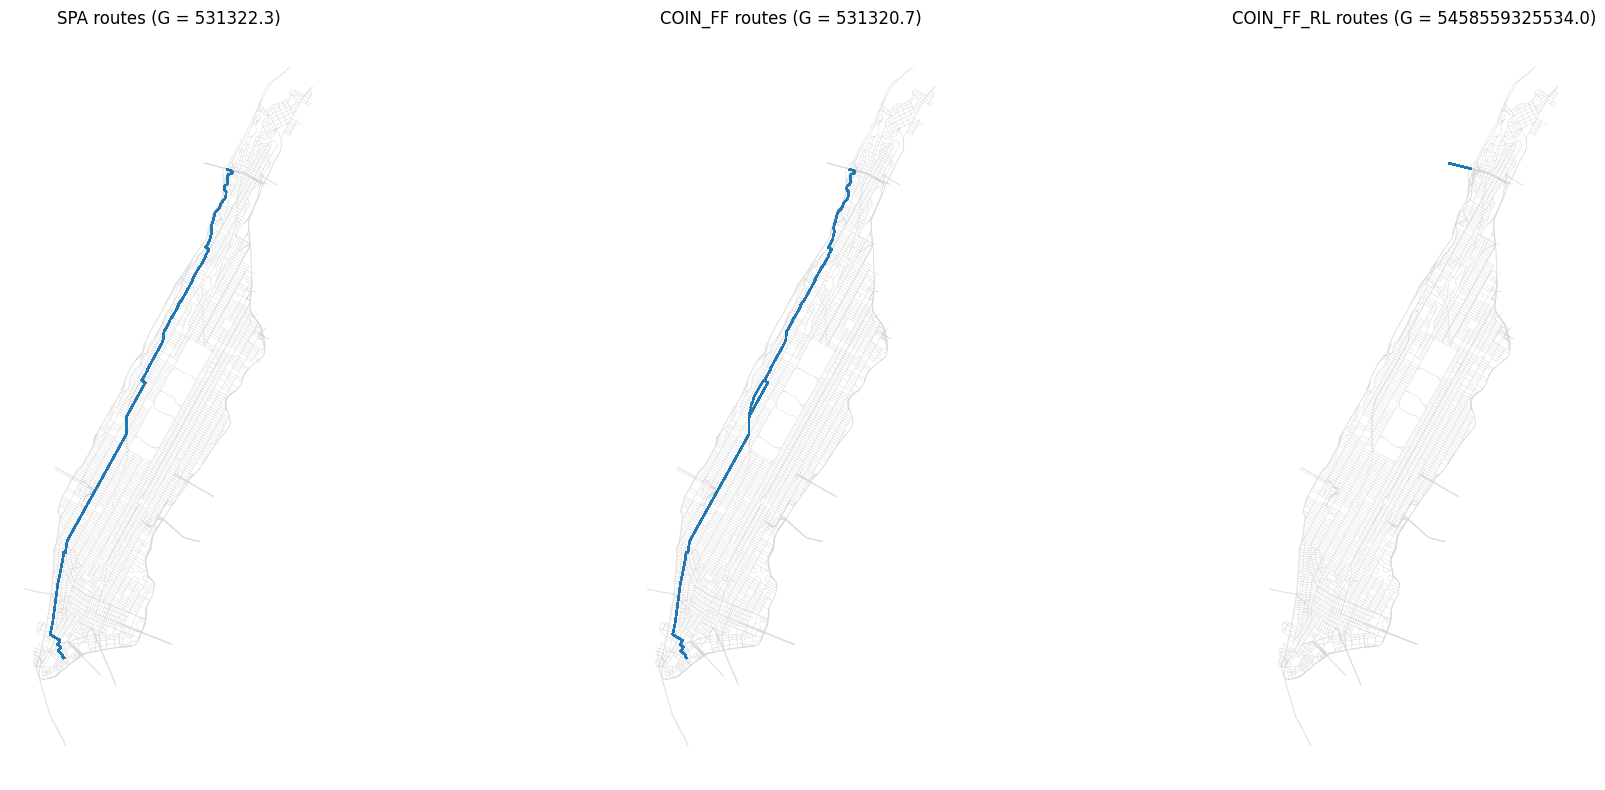

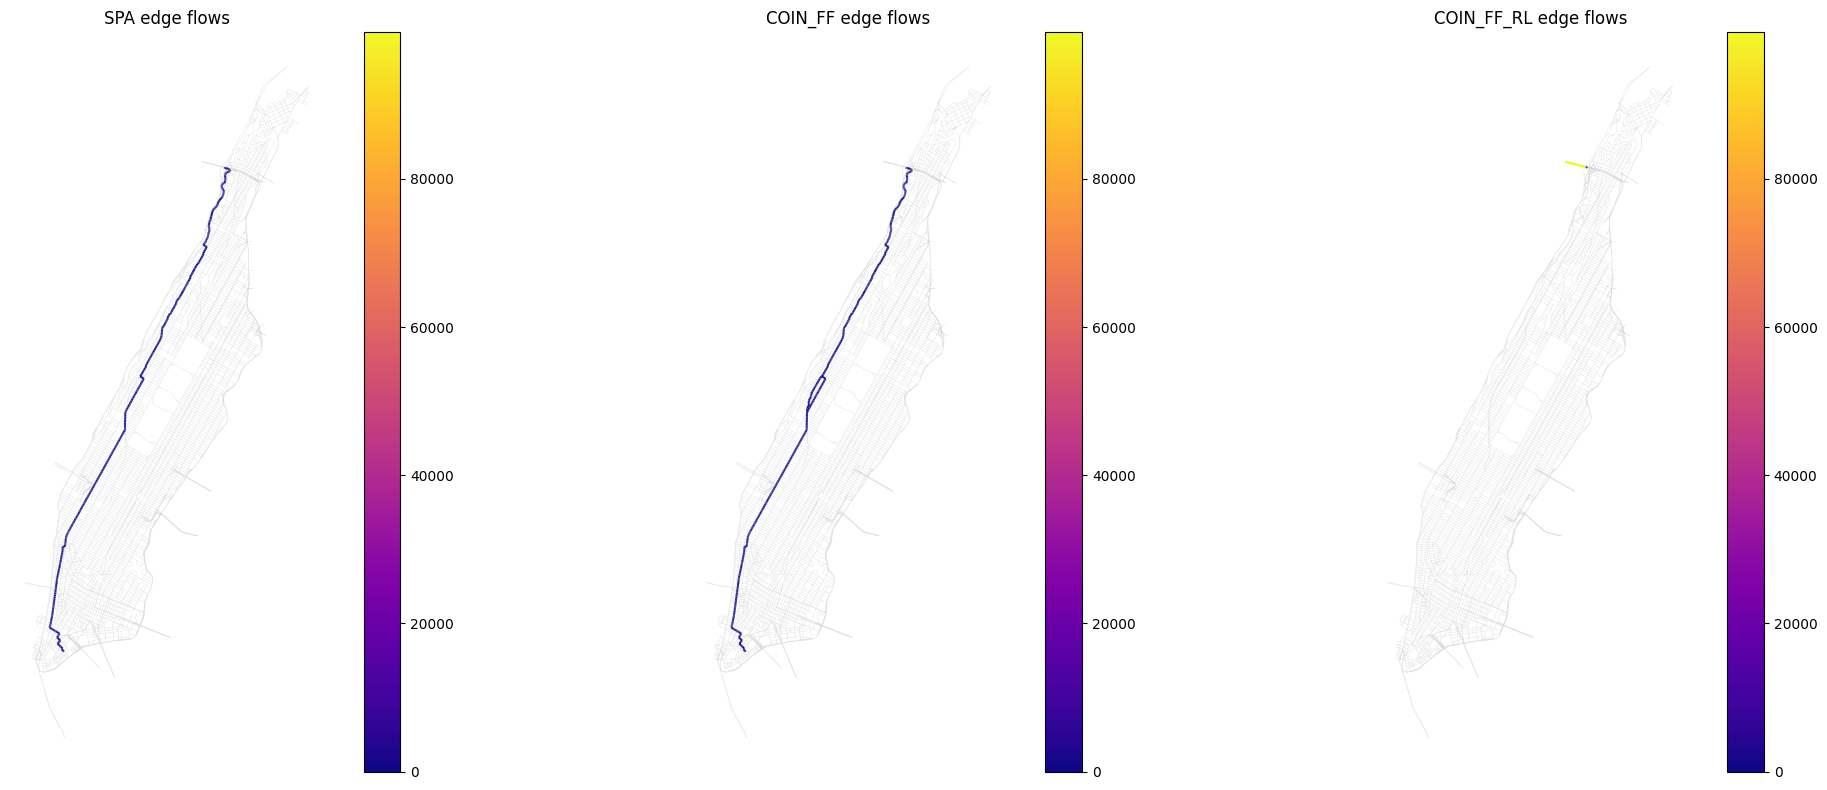

In [34]:
random.seed(26)
num_agents = 100  # baseline per scenario

(
    agents_spa,
    flows_spa,
    G_spa,
    agents_coin_ff,
    flows_coin_ff,
    G_coin_ff,
    agents_coin_ff_rl,
    flows_coin_ff_rl,
    G_coin_ff_rl,
    Q_rl,
) = run_coin_ff_true_rl_experiment(
    manhattan_network,
    num_agents_baseline=num_agents,
    num_agents_train=num_agents,   # agents per training episode
    num_agents_eval_rl=num_agents,
    od_mode="fixed",
    num_episodes=50,               # tweak for compute vs quality
)


# --- fractions reaching destination ---
print("\nSPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN_FF fraction reaching dest:", fraction_reached(agents_coin_ff, destination))
print("COIN_FF_RL fraction reaching dest:", fraction_reached(agents_coin_ff_rl, destination))

# --- per-scenario metrics (avg time & distance) ---
print_scenario_metrics(
    "SPA",
    network=manhattan_network,
    flows=flows_spa,
    G=G_spa,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF",
    network=manhattan_network,
    flows=flows_coin_ff,
    G=G_coin_ff,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF_RL",
    network=manhattan_network,
    flows=flows_coin_ff_rl,
    G=G_coin_ff_rl,
    num_agents=num_agents,
)

# --- Route plots ---
# plot_routes_spa_vs_coin_ff(gdf, agents_spa, G_spa, agents_coin_ff, G_coin_ff)
# plot_routes_spa_vs_coin_ff_rl(gdf, agents_spa, G_spa, agents_coin_ff_rl, G_coin_ff_rl)
plot_routes_three_way(
    gdf,
    agents_spa,      G_spa,
    agents_coin_ff,  G_coin_ff,
    agents_coin_ff_rl, G_coin_ff_rl
)

# --- Heatmaps ---
# plot_heatmaps_spa_vs_coin_ff(gdf, manhattan_network, flows_spa, flows_coin_ff)
# plot_heatmaps_spa_vs_coin_ff_rl(gdf, manhattan_network, flows_spa, flows_coin_ff_rl)
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_coin_ff,
    flows_coin_ff_rl
)